## second.ipynb

In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import json
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
def create_u_data(slice_path):
    path = (slice_path)
    f = open(path)
    data = json.load(f)
    
    res = [] # [userid, trackid]
    for i in tqdm(data['playlists']):
        playlist_name = i['name']
        for j in i['tracks']:
            res.append([playlist_name, j['track_name'], 1])
    df = pd.DataFrame(res, columns=['p_name', 't_name', 'rating'])
    df['t_name'] = df['t_name'].astype('string')
    df['t_name'] = pd.Categorical(df['t_name'])
    df['p_name'] = df['p_name'].astype('string')
    df['p_name'] = pd.Categorical(df['p_name'])
    df['rating'] = df['rating'].astype('int32')

    df['p_num'] = df.p_name.cat.codes
    df['t_num'] = df.t_name.cat.codes
    df['timestamp'] = 1234

    del df['p_name']
    del df['t_name']
    df.reset_index()
    df = df[['p_num', 't_num', 'rating', 'timestamp']]
    df.to_csv('./Data/u.data', index=False)

create_u_data('./Data/mpd.slice.0-999.json')

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10921.10it/s]


## Test Train split

In [20]:
import pandas as pd
import numpy as np

INPUT_PATH = './Data/u.data'
OUTPUT_PATH_TRAIN = './Data/spotify.train.rating'
OUTPUT_PATH_TEST = './Data/spotify.test.rating'
USER_FIELD = 'p_num'

def save_to_csv(df,path, header = False, index = False, sep = '\t', verbose = False):
    if verbose:
        print("Saving df to path: {}".format(path))
        print("Columns in df are: {}".format(df.columns.tolist()))

    df.to_csv(path, header = header, index = index, sep = sep)

def get_train_test_df(transactions):
    '''
    return train and test dataframe, with leave the latest one out strategy
    Args:
        transactions: the entire df of user/item transactions
    '''

    print("Size of the entire dataset:{}".format(transactions.shape))
    transactions.sort_values(by = ['timestamp'], inplace = True)
    last_transaction_mask = transactions.duplicated(subset = {USER_FIELD}, keep = "last")
    # The last transaction mask has all the latest items of people
    # We want for the test dataset, items marked with a False
    train_df = transactions[last_transaction_mask]
    test_df = transactions[~last_transaction_mask]
    
    train_df.sort_values(by=["p_num", 'timestamp'], inplace = True)
    test_df.sort_values(by=["p_num", 'timestamp'], inplace = True)
    return train_df, test_df

def report_stats(transactions, train_df, test_df):
    whole_size = transactions.shape[0]*1.0
    train_size = train_df.shape[0]
    test_size = test_df.shape[0]
    print("Total No. of Records = {}".format(whole_size))
    print("Train size = {}, Test size = {}".format(train_size, test_size))
    print("Train % = {}, Test % ={}".format(train_size/whole_size, test_size/whole_size))

transactions = pd.read_csv(INPUT_PATH)
# make the dataset
train_df, test_df = get_train_test_df(transactions)
save_to_csv(train_df, OUTPUT_PATH_TRAIN, header = False,index = False, verbose = 1)
save_to_csv(test_df, OUTPUT_PATH_TEST,header = False,index = False, verbose = 1)
report_stats(transactions, train_df, test_df)

Size of the entire dataset:(67503, 4)
Saving df to path: ./spotify.train.rating
Columns in df are: ['p_num', 't_num', 'rating', 'timestamp']


<ipython-input-20-f2202f80b1a8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["p_num", 'timestamp'], inplace = True)
<ipython-input-20-f2202f80b1a8>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.sort_values(by=["p_num", 'timestamp'], inplace = True)


Saving df to path: ./spotify.test.rating
Columns in df are: ['p_num', 't_num', 'rating', 'timestamp']
Total No. of Records = 67503.0
Train size = 66634, Test size = 869
Train % = 0.9871264980815667, Test % =0.012873501918433256


In [23]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)

# Workspace imports
from evaluate import evaluate_model
from Dataset import MovieLensDataset
from utils import train_one_epoch, test, plot_statistics

# Python imports
import argparse
from time import time
import numpy as np
import pickle

In [24]:
class MLP(nn.Module):

    def __init__(self, n_users, n_items, layers=[16, 8], dropout=False):
        """
        Simple Feedforward network with Embeddings for users and items
        """
        super().__init__()
        assert (layers[0] % 2 == 0), "layers[0] must be an even number"
        self.__alias__ = "MLP {}".format(layers)
        self.__dropout__ = dropout

        # user and item embedding layers
        embedding_dim = int(layers[0]/2)
        self.user_embedding = torch.nn.Embedding(n_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(n_items, embedding_dim)

        # list of weight matrices
        self.fc_layers = torch.nn.ModuleList()
        # hidden dense layers
        for _, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        # final prediction layer
        self.output_layer = torch.nn.Linear(layers[-1], 1)

    def forward(self, feed_dict):
        users = feed_dict['user_id']
        items = feed_dict['item_id']
        user_embedding = self.user_embedding(users)
        item_embedding = self.item_embedding(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([user_embedding, item_embedding], 1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            x = self.fc_layers[idx](x)
            x = F.relu(x)
            x = F.dropout(x,  p=self.__dropout__, training=self.training)
        logit = self.output_layer(x)
        rating = torch.sigmoid(logit)
        return rating

    def predict(self, feed_dict):
        # return the score, inputs and outputs are numpy arrays
        for key in feed_dict:
            if type(feed_dict[key]) != type(None):
                feed_dict[key] = torch.from_numpy(
                    feed_dict[key]).to(dtype=torch.long, device=device)
        output_scores = self.forward(feed_dict)
        return output_scores.cpu().detach().numpy()

    def get_alias(self):
        return self.__alias__


In [27]:
path = 'Data/'
dataset = 'spotify'
layers = eval('[16,32,16,8]')
weight_decay = 1e-5
num_negatives_train = 4
num_negatives_test = 100
dropout = 0
learner = 'adam'
learning_rate = 1e-2
batch_size = 64
epochs = 20
verbose = 1

In [29]:
topK = 10
full_dataset = MovieLensDataset(
        path + dataset, num_negatives_train=num_negatives_train, num_negatives_test=num_negatives_test)
train, testRatings, testNegatives = full_dataset.trainMatrix, full_dataset.testRatings, full_dataset.testNegatives
num_users, num_items = train.shape
print("#user=%d, #item=%d, #train=%d, #test=%d"
      % (num_users, num_items, train.nnz, len(testRatings)))

training_data_generator = DataLoader(
    full_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

#user=869, #item=30049, #train=64318, #test=869


In [30]:
model = MLP(num_users, num_items, layers=layers, dropout=dropout)
# Transfer the model to GPU, if one is available
model.to(device)
if verbose:
    print(model)

MLP(
  (user_embedding): Embedding(869, 8)
  (item_embedding): Embedding(30049, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)


In [33]:
loss_fn = torch.nn.BCELoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

# Record performance
hr_list = []
ndcg_list = []
BCE_loss_list = []

# Check Init performance
hr, ndcg = test(model, full_dataset, topK)
hr_list.append(hr)
ndcg_list.append(ndcg)
BCE_loss_list.append(1)

for epoch in range(epochs):
    epoch_loss = train_one_epoch( model, training_data_generator, loss_fn, optimizer, epoch, device)

    if epoch % verbose == 0:
        hr, ndcg = test(model, full_dataset, topK)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        BCE_loss_list.append(epoch_loss)
        # if hr > best_hr:
        #     best_hr, best_ndcg, best_iter = hr, ndcg, epoch
        #     if args.out > 0:
        #         model.save(model_out_file, overwrite=True)
    print("hr for epochs: ", hr_list)
    print("ndcg for epochs: ", ndcg_list)
    print("loss for epochs: ", BCE_loss_list)
    # plot_statistics(hr_list, ndcg_list, BCE_loss_list,model.get_alias(), "./figs")
    # with open("metrics", 'wb') as fp:
    #     pickle.dump(hr_list, fp)
    #     pickle.dump(ndcg_list, fp)

    best_iter = np.argmax(np.array(hr_list))
    best_hr = hr_list[best_iter]
    best_ndcg = ndcg_list[best_iter]
    print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %
          (best_iter, best_hr, best_ndcg))
    # if args.out > 0:
    #     print("The best MLP model is saved to %s" %(model_out_file))

Eval: HR = 0.0990, NDCG = 0.0488 [2.8 s]
Epoch = 0
Epoch completed 21.6 s
Train Loss: 0.49146691901766837
Eval: HR = 0.3257, NDCG = 0.1843 [1.3 s]
hr for epochs:  [0.09896432681242807, 0.3256616800920598]
ndcg for epochs:  [0.048837112879771584, 0.18433498631730463]
loss for epochs:  [1, 0.49146691901766837]
End. Best Iteration 1:  HR = 0.3257, NDCG = 0.1843. 
Epoch = 1
Epoch completed 15.0 s
Train Loss: 0.4479121490912651
Eval: HR = 0.3705, NDCG = 0.2154 [0.8 s]
hr for epochs:  [0.09896432681242807, 0.3256616800920598, 0.3705408515535098]
ndcg for epochs:  [0.048837112879771584, 0.18433498631730463, 0.2153859737086956]
loss for epochs:  [1, 0.49146691901766837, 0.4479121490912651]
End. Best Iteration 2:  HR = 0.3705, NDCG = 0.2154. 
Epoch = 2
Epoch completed 13.0 s
Train Loss: 0.42569876524642924
Eval: HR = 0.3740, NDCG = 0.2166 [0.8 s]
hr for epochs:  [0.09896432681242807, 0.3256616800920598, 0.3705408515535098, 0.3739930955120829]
ndcg for epochs:  [0.048837112879771584, 0.184334986

Epoch completed 13.4 s
Train Loss: 0.21245620807011922
Eval: HR = 0.3142, NDCG = 0.1661 [0.7 s]
hr for epochs:  [0.09896432681242807, 0.3256616800920598, 0.3705408515535098, 0.3739930955120829, 0.3751438434982739, 0.37284234752589185, 0.3532796317606444, 0.3440736478711162, 0.33601841196777904, 0.3141542002301496, 0.32681242807825084, 0.31185270425776757, 0.2945914844649022, 0.30609896432681244, 0.3141542002301496]
ndcg for epochs:  [0.048837112879771584, 0.18433498631730463, 0.2153859737086956, 0.2165519526168355, 0.21551624030118421, 0.2159094328637498, 0.20299016712509138, 0.19576036272037645, 0.18989794586559716, 0.1800699008720991, 0.18456230979818192, 0.17406469549441608, 0.1600820439714877, 0.1714565179526761, 0.1661117497292812]
loss for epochs:  [1, 0.49146691901766837, 0.4479121490912651, 0.42569876524642924, 0.40763223937791376, 0.38356360240065634, 0.3570349966234236, 0.33222584743701405, 0.3088477443581197, 0.288153278350237, 0.26871610593884737, 0.25275865641844214, 0.237

## Training using fastai v2

In [7]:
from fastai.collab import *

In [8]:
dls = CollabDataLoaders.from_df(df, bs=64, item_name='title')
dls.show_batch()

,userId,title,rating
0,542,This Year's Love,1
1,830,Don't Blame Yourself,1
2,529,Two Princes,1
3,229,For Free,1
4,294,Amnesia,1
5,752,Casual Sex,1
6,275,White Iverson,5
7,702,Nothing Compares 2 U,1
8,163,Some Sunsick Day,1
9,95,Intervention,1


In [13]:
from fastai.losses import BCEWithLogitsLossFlat
learn = collab_learner(dls, y_range=[0,5.5], n_factors=150)

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.3182567499825382e-06)

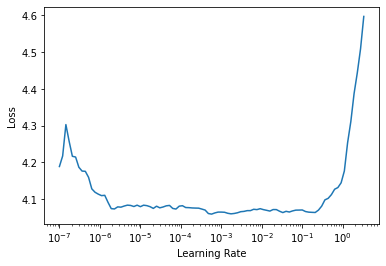

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(10,1e-3)

KeyboardInterrupt: 

In [162]:
learn.save('./saved_model')

Path('models/saved_model.pth')

In [16]:
learn.show_results()

,userId,title,rating,rating_pred
0,529,18756,1,3.366180
1,755,6135,1,2.916562
2,65,1417,5,2.860280
3,404,22022,5,2.579245
4,360,15380,5,2.860852
5,431,13040,5,2.516624
6,38,2964,5,2.600452
7,466,11083,1,3.291556
8,452,1398,1,2.704370


## Results

In [17]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(870, 150)
  (i_weight): Embedding(30811, 150)
  (u_bias): Embedding(870, 1)
  (i_bias): Embedding(30811, 1)
)

In [18]:
g = df.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Closer', 'Broccoli (feat. Lil Yachty)', 'One Dance', 'Roses',
       'Ride', 'Congratulations', 'HUMBLE.', 'goosebumps',
       "Don't Let Me Down", 'Home'], dtype=object)

In [19]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

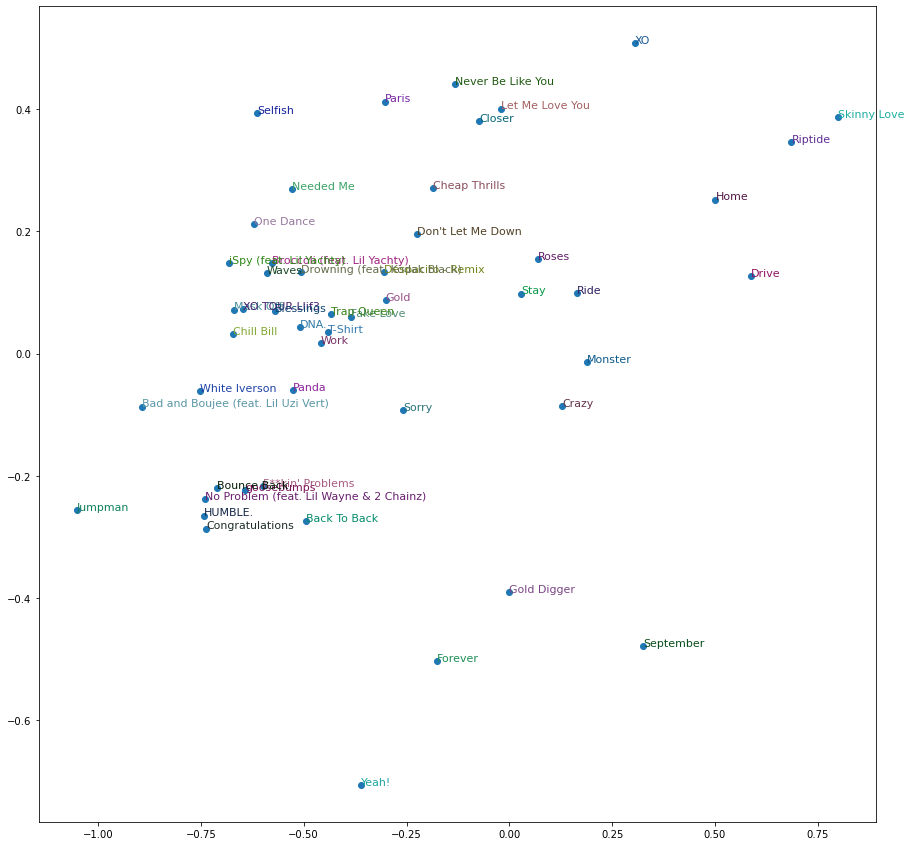

In [20]:
import matplotlib.pyplot as plt
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()